In [128]:
from paths import (LJLISTS_DIR, LOGS_DIR, 
                  WAVS_DIR, ENCODED_AUDIO_EN_DIR,
                  DATA_DIR, CKPT_DIR,) 
import numpy as np
from utils import normalize_pitch_channel, smooth_multivariate_signal
import pandas as pd
from tqdm import tqdm
from pathlib import Path

version = "v1"
grad_filename = "grad_4750.pt"
version_dir = LOGS_DIR / version

In [129]:
import torch
from model import ArtTTS
from configs import params_v1

from data_phnm import PhnmArticDataset, PhnmArticBatchCollate, PhnmBatchCollate
from torch.utils.data import DataLoader

## Test lengths predictions

In [130]:
device='cpu'

model = ArtTTS(
        params_v1.n_ipa_feats,
        params_v1.n_spks,
        None if params_v1.n_spks == 1 else params_v1.spk_emb_dim,  # spk_emb_dim
        params_v1.n_enc_channels,
        params_v1.filter_channels,
        params_v1.filter_channels_dp,
        params_v1.n_heads,
        params_v1.n_enc_layers,
        params_v1.enc_kernel,
        params_v1.enc_dropout,
        params_v1.window_size,
        params_v1.n_feats,
        params_v1.dec_dim,
        params_v1.beta_min,
        params_v1.beta_max,
        params_v1.pe_scale,
    ).to(device)

ckpt_filepath = CKPT_DIR / version / "grad_4750.pt"
ckpt_state_dict = torch.load(ckpt_filepath, map_location=torch.device(device))

model.load_state_dict(ckpt_state_dict)

reorder_feats = params_v1.reorder_feats
collator = PhnmBatchCollate()

In [131]:
dataset = "MNGU0"
speaker = "s1"

dataset_obj = PhnmArticDataset(
        f"resources/filelists/{dataset}/{speaker}_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )
filepaths_list = dataset_obj.filepaths_list

### individual sample

In [5]:
sample_id = "mngu0_s1_0001"
phnm3_fp = DATA_DIR / dataset / "arttts" / speaker / "phnm3" / f"{sample_id}_phnm3.npy"
phnm3 = np.load(phnm3_fp)

In [6]:
phnm3_fp = f'DUMMY/MNGU0/arttts/s1/phnm3/{sample_id}_phnm3.npy'
phnm_emb = dataset_obj.get_phnm_emb(phnm3_fp)
phnm_embs = [{"x" : phnm_emb} for i in range(1)]
batch = collator(phnm_embs)
x = batch["x"].to(torch.float32)
x_lengths = batch["x_lengths"]

In [7]:
from text.phnms import get_lengths_from_phnm3, get_phnms_from_phnm3

model.eval()                                                                                                                                                                                                 
frames_pred = model.lengths_pred(x, x_lengths).squeeze().squeeze()  # (B, T_x) -> (T_x,)
len_pred =  frames_pred / 50
uplen_pred = torch.ceil(frames_pred) / 50
len_gt = dataset_obj.get_x_durations(phnm3_fp, merge_diphtongues=params_v1.merge_diphtongues) / 50
phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)

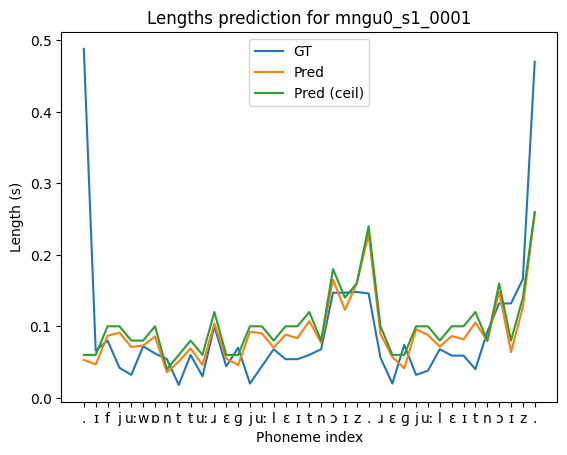

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(len_gt)), len_gt, label="GT")
plt.plot(np.arange(len(len_gt)), len_pred, label="Pred")
plt.plot(np.arange(len(len_gt)), uplen_pred, label="Pred (ceil)")
plt.legend()
plt.title(f"Lengths prediction for {sample_id}")
plt.xlabel("Phoneme index")
plt.xticks(np.arange(len(len_gt)), phnms)
plt.ylabel("Length (s)")
plt.show()

# Phoneme level analysis

In [132]:
from text.phnms import get_phnms_from_phnm3
from text.converters import arpabet2ipa

lj_ipa_set = set(arpabet2ipa.values())

## MNGU0

In [188]:
from utils_dataset.mngu0 import mngu02ipa

mngu0_ipa_set = set(mngu02ipa.values())
extra_ipa_set = mngu0_ipa_set - lj_ipa_set

dataset = "MNGU0"
speakers = ["s1"]

In [190]:
from text.phnms import get_phnms_from_phnm3, get_lengths_from_phnm3

summary_df = None

model.eval()
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    dataset_obj = PhnmArticDataset(
        f"resources/filelists/{dataset}/{speaker}_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )
    filepaths_list = dataset_obj.filepaths_list
    for e in tqdm(filepaths_list):    
        sample_id = Path(e[0]).stem
        phnm3_fp = e[1]
        phnm3_abs_fp = phnm3_fp.replace("DUMMY/", str(DATA_DIR) + "/")
        phnm3 = np.load(phnm3_abs_fp)
        len_gt = get_lengths_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        # Load the phoneme embedding
        phnm_emb = dataset_obj.get_phnm_emb(phnm3_fp)
        phnm_embs = [{"x" : phnm_emb} for i in range(1)]
        batch = collator(phnm_embs)
        x = batch["x"].to(torch.float32)
        x_lengths = batch["x_lengths"]
        # predict lengths
        frames_pred = model.lengths_pred(x, x_lengths).squeeze().squeeze()  # (B, T_x) -> (T_x,)
        len_pred =  frames_pred / 50
        uplen_pred = torch.ceil(frames_pred) / 50
        file_df = pd.DataFrame({
                "sample_id": [sample_id for _ in range(len(phnms))],
                "speaker": [speaker for _ in range(len(phnms))],
                "phnms": phnms,
                "len_gt": len_gt.tolist(),
                "len_pred": len_pred.tolist(),
                "uplen_pred": uplen_pred.tolist(),
                })
        if summary_df is None:
            summary_df = file_df
        else:
            summary_df = pd.concat([summary_df, file_df], ignore_index=True)
        
    summary_df[summary_df["speaker"] == speaker].to_csv(analysis_dir / "lengths_preds.csv", index=False)

100%|██████████| 1354/1354 [00:25<00:00, 53.56it/s]


In [191]:
dataset = "MNGU0"
speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
summary_df = pd.read_csv(analysis_dir / "lengths_preds.csv")

summary_df["len_err"] = summary_df["len_pred"] - summary_df["len_gt"]
summary_df["uplen_err"] = summary_df["uplen_pred"] - summary_df["len_gt"]
summary_df["len_err2"] = (summary_df["len_pred"] - summary_df["len_gt"])**2
summary_df["uplen_err2"] = (summary_df["uplen_pred"] - summary_df["len_gt"])**2
summary_df["len_err_rel"] = summary_df["len_err"] / summary_df["len_gt"]
summary_df["uplen_err_rel"] = summary_df["uplen_err"] / summary_df["len_gt"]

In [193]:
phnms_df = summary_df.groupby("phnms").mean(['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']).sort_values(by="len_err_rel")

phnms_stds_df = summary_df.groupby("phnms")[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']].std().sort_values(by="len_err_rel")
phnms_df["extra_ipa"] = phnms_df.index.isin(extra_ipa_set)

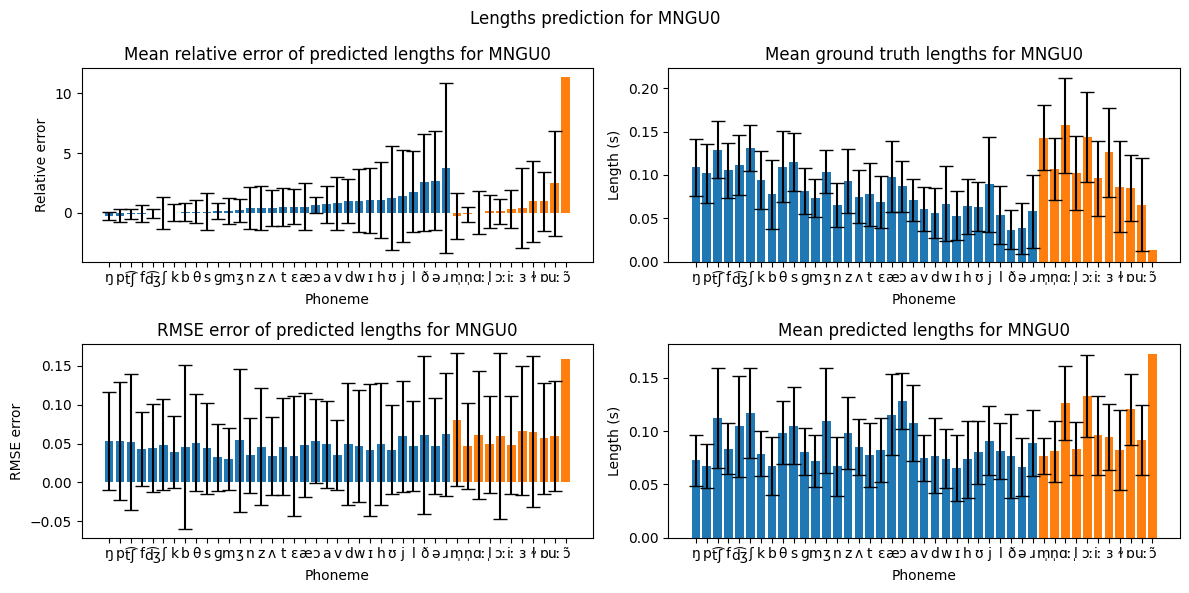

In [194]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

axes = ax.flatten()

phnms_regular_df = phnms_df[~phnms_df["extra_ipa"]]
phnms_extra_df = phnms_df[phnms_df["extra_ipa"]]
phnms_extra_df = phnms_extra_df.drop(index=["."])

phnms_stds_regular_df = phnms_stds_df.loc[phnms_regular_df.index]
phnms_stds_extra_df = phnms_stds_df.loc[phnms_extra_df.index]

axes[0].bar(phnms_regular_df.index, phnms_regular_df["len_err_rel"], yerr=phnms_stds_regular_df["len_err_rel"], capsize=5)
axes[0].bar(phnms_extra_df.index, phnms_extra_df["len_err_rel"], yerr=phnms_stds_extra_df["len_err_rel"], capsize=5)
axes[0].set_title(f"Mean relative error of predicted lengths for {dataset}")
axes[0].set_xlabel("Phoneme")
axes[0].set_ylabel("Relative error")

axes[1].bar(phnms_regular_df.index, phnms_regular_df["len_gt"], yerr=phnms_stds_regular_df["len_gt"], capsize=5)
axes[1].bar(phnms_extra_df.index, phnms_extra_df["len_gt"], yerr=phnms_stds_extra_df["len_gt"], capsize=5)
axes[1].set_title(f"Mean ground truth lengths for {dataset}")
axes[1].set_xlabel("Phoneme")
axes[1].set_ylabel("Length (s)")

axes[2].bar(phnms_regular_df.index, np.sqrt(phnms_regular_df["len_err2"]), yerr=np.sqrt(phnms_stds_regular_df["len_err2"]), capsize=5)
axes[2].bar(phnms_extra_df.index, np.sqrt(phnms_extra_df["len_err2"]), yerr=np.sqrt(phnms_stds_extra_df["len_err2"]), capsize=5)
axes[2].set_title(f"RMSE error of predicted lengths for {dataset}")
axes[2].set_xlabel("Phoneme")
axes[2].set_ylabel("RMSE error")

axes[3].bar(phnms_regular_df.index, phnms_regular_df["len_pred"], yerr=phnms_stds_regular_df["len_pred"], capsize=5)
axes[3].bar(phnms_extra_df.index, phnms_extra_df["len_pred"], yerr=phnms_stds_extra_df["len_pred"], capsize=5)
axes[3].set_title(f"Mean predicted lengths for {dataset}")
axes[3].set_xlabel("Phoneme")
axes[3].set_ylabel("Length (s)")

plt.suptitle(f"Lengths prediction for {dataset}")
plt.tight_layout()

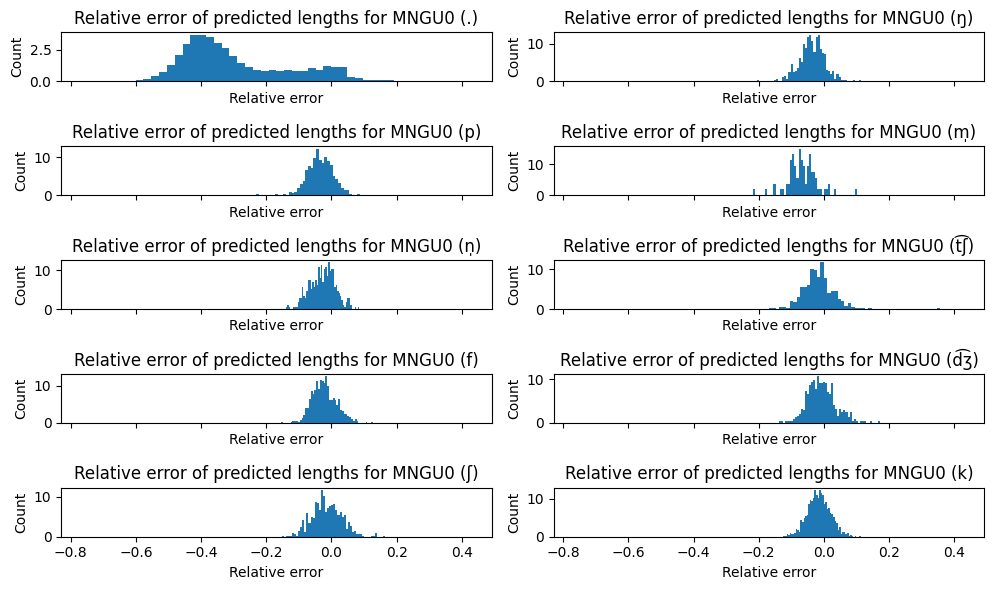

In [195]:
phnm = list(mngu0_ipa_set)[2]
fig, ax = plt.subplots(5,2,figsize=(10, 6), sharex=True)
axes = ax.flatten()
for i, phnm in enumerate(phnms_df.index[:10]):
    truc = summary_df[summary_df["phnms"] == phnm]
    axes[i].hist(truc["len_err"], density=True, bins=50)
    axes[i].set_title(f"Relative error of predicted lengths for {dataset} ({phnm})")
    axes[i].set_xlabel("Relative error")
    axes[i].set_ylabel("Count")
plt.tight_layout()

## pb2007

In [157]:
from utils_dataset.pb2007 import pb20072ipa

pb2007_ipa_set = set(pb20072ipa.values())
extra_ipa_set = pb2007_ipa_set - lj_ipa_set

dataset = "pb2007"
speakers = ["spk1"]

In [ ]:
from text.phnms import get_phnms_from_phnm3, get_lengths_from_phnm3

summary_df = None

dataset = "pb2007"
model.eval()
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    dataset_obj = PhnmArticDataset(
        f"resources/filelists/{dataset}/{speaker}_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )
    filepaths_list = dataset_obj.filepaths_list
    for e in tqdm(filepaths_list):
        sample_id = Path(e[0]).stem
        phnm3_fp = e[1]
        phnm3_abs_fp = phnm3_fp.replace("DUMMY/", str(DATA_DIR) + "/")
        phnm3 = np.load(phnm3_abs_fp)
        len_gt = get_lengths_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        # Load the phoneme embedding
        phnm_emb = dataset_obj.get_phnm_emb(phnm3_fp)
        phnm_embs = [{"x" : phnm_emb} for i in range(1)]
        batch = collator(phnm_embs)
        x = batch["x"].to(torch.float32)
        x_lengths = batch["x_lengths"]
        # predict lengths
        frames_pred = model.lengths_pred(x, x_lengths).squeeze().squeeze()  # (B, T_x) -> (T_x,)
        len_pred =  frames_pred / 50
        uplen_pred = torch.ceil(frames_pred) / 50
        file_df = pd.DataFrame({
                "sample_id": [sample_id for _ in range(len(phnms))],
                "speaker": [speaker for _ in range(len(phnms))],
                "phnms": phnms,
                "len_gt": len_gt.tolist(),
                "len_pred": len_pred.tolist(),
                "uplen_pred": uplen_pred.tolist(),
                })
        if summary_df is None:
            summary_df = file_df
        else:
            summary_df = pd.concat([summary_df, file_df], ignore_index=True)
    summary_df[summary_df["speaker"] == speaker].to_csv(analysis_dir / "lengths_preds.csv", index=False)
        
summary_df

100%|██████████| 1109/1109 [00:56<00:00, 19.69it/s]


,sample_id,speaker,phnms,len_gt,len_pred,uplen_pred
0,item_0926,spk1,.,0.15,0.043655,0.06
1,item_0926,spk1,w,0.19,0.049530,0.06
2,item_0926,spk1,a,0.25,0.081114,0.10
3,item_0926,spk1,j,0.19,0.102922,0.12
4,item_0926,spk1,ə,0.08,0.102715,0.12
...,...,...,...,...,...,...
7345,item_0187,spk1,.,0.15,0.055557,0.06
7346,item_0187,spk1,ø,0.25,0.078765,0.08
7347,item_0187,spk1,l,0.31,0.101714,0.12
7348,item_0187,spk1,ø,0.30,0.086615,0.10


In [158]:
summary_df = None
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    speaker_df = pd.read_csv(analysis_dir / "lengths_preds.csv")
    if summary_df is None:
        summary_df = speaker_df
    else:
        summary_df = pd.concat([summary_df, speaker_df], ignore_index=True)

summary_df["len_err"] = summary_df["len_pred"] - summary_df["len_gt"]
summary_df["uplen_err"] = summary_df["uplen_pred"] - summary_df["len_gt"]
summary_df["len_err2"] = (summary_df["len_pred"] - summary_df["len_gt"])**2
summary_df["uplen_err2"] = (summary_df["uplen_pred"] - summary_df["len_gt"])**2
summary_df["len_err_rel"] = summary_df["len_err"] / summary_df["len_gt"]
summary_df["uplen_err_rel"] = summary_df["uplen_err"] / summary_df["len_gt"]

In [147]:
phnms_df = summary_df.groupby("phnms").mean(['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']).sort_values(by="len_err_rel")

phnms_stds_df = summary_df.groupby("phnms")[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']].std().sort_values(by="len_err_rel")
phnms_df["extra_ipa"] = phnms_df.index.isin(extra_ipa_set)

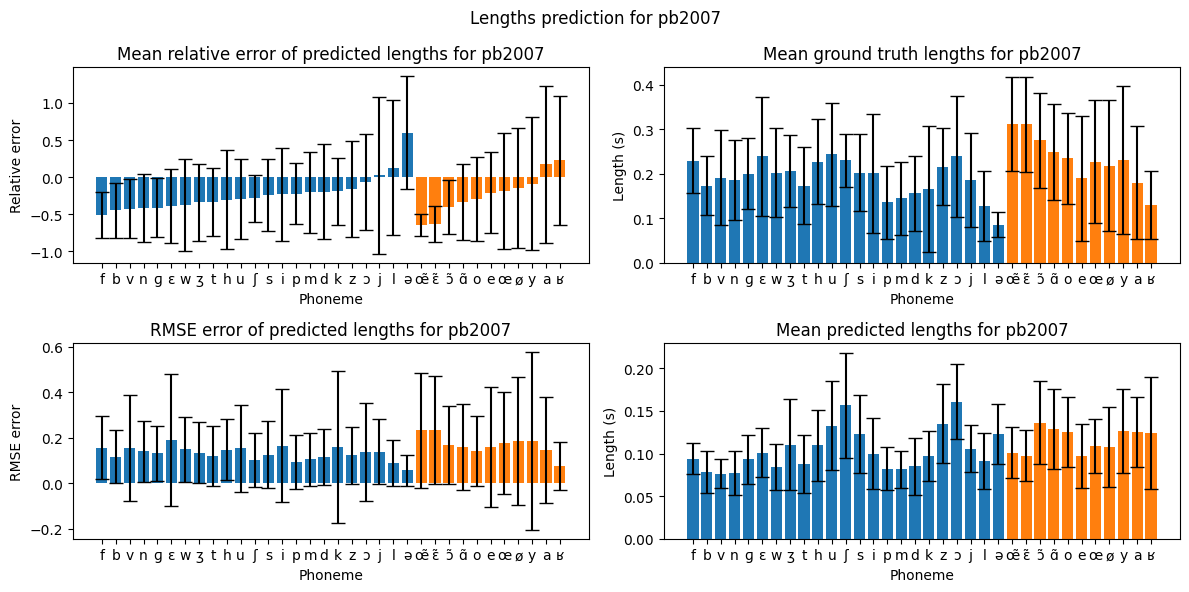

In [149]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

axes = ax.flatten()

phnms_regular_df = phnms_df[~phnms_df["extra_ipa"]]
phnms_extra_df = phnms_df[phnms_df["extra_ipa"]]
phnms_extra_df = phnms_extra_df.drop(index=["."])

phnms_stds_regular_df = phnms_stds_df.loc[phnms_regular_df.index]
phnms_stds_extra_df = phnms_stds_df.loc[phnms_extra_df.index]

axes[0].bar(phnms_regular_df.index, phnms_regular_df["len_err_rel"], yerr=phnms_stds_regular_df["len_err_rel"], capsize=5)
axes[0].bar(phnms_extra_df.index, phnms_extra_df["len_err_rel"], yerr=phnms_stds_extra_df["len_err_rel"], capsize=5)
axes[0].set_title(f"Mean relative error of predicted lengths for {dataset}")
axes[0].set_xlabel("Phoneme")
axes[0].set_ylabel("Relative error")

axes[1].bar(phnms_regular_df.index, phnms_regular_df["len_gt"], yerr=phnms_stds_regular_df["len_gt"], capsize=5)
axes[1].bar(phnms_extra_df.index, phnms_extra_df["len_gt"], yerr=phnms_stds_extra_df["len_gt"], capsize=5)
axes[1].set_title(f"Mean ground truth lengths for {dataset}")
axes[1].set_xlabel("Phoneme")
axes[1].set_ylabel("Length (s)")

axes[2].bar(phnms_regular_df.index, np.sqrt(phnms_regular_df["len_err2"]), yerr=np.sqrt(phnms_stds_regular_df["len_err2"]), capsize=5)
axes[2].bar(phnms_extra_df.index, np.sqrt(phnms_extra_df["len_err2"]), yerr=np.sqrt(phnms_stds_extra_df["len_err2"]), capsize=5)
axes[2].set_title(f"RMSE error of predicted lengths for {dataset}")
axes[2].set_xlabel("Phoneme")
axes[2].set_ylabel("RMSE error")

axes[3].bar(phnms_regular_df.index, phnms_regular_df["len_pred"], yerr=phnms_stds_regular_df["len_pred"], capsize=5)
axes[3].bar(phnms_extra_df.index, phnms_extra_df["len_pred"], yerr=phnms_stds_extra_df["len_pred"], capsize=5)
axes[3].set_title(f"Mean predicted lengths for {dataset}")
axes[3].set_xlabel("Phoneme")
axes[3].set_ylabel("Length (s)")

plt.suptitle(f"Lengths prediction for {dataset}")
plt.tight_layout()

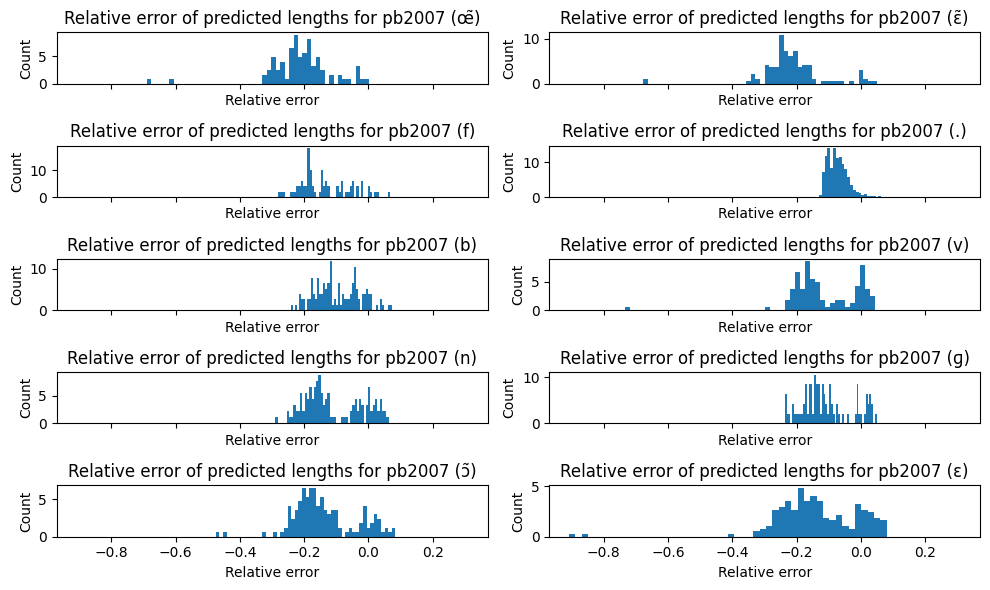

In [150]:
phnm = list(pb2007_ipa_set)[2]
fig, ax = plt.subplots(5,2,figsize=(10, 6), sharex=True)
axes = ax.flatten()
for i, phnm in enumerate(phnms_df.index[:10]):
    truc = summary_df[summary_df["phnms"] == phnm]
    axes[i].hist(truc["len_err"], density=True, bins=50)
    axes[i].set_title(f"Relative error of predicted lengths for {dataset} ({phnm})")
    axes[i].set_xlabel("Relative error")
    axes[i].set_ylabel("Count")
plt.tight_layout()

## MSPKA_EMA_ita

In [160]:
from utils_dataset.mspka import mspka2ipa

mspka_ipa_set = set(mspka2ipa.values())
extra_ipa_set = mspka_ipa_set - lj_ipa_set

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]

In [161]:
from text.phnms import get_phnms_from_phnm3, get_lengths_from_phnm3

dataset = "MSPKA_EMA_ita"
summary_df = None

model.eval()
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    dataset_obj = PhnmArticDataset(
        f"resources/filelists/{dataset}/{speaker}_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )
    filepaths_list = dataset_obj.filepaths_list
    for e in tqdm(filepaths_list):
        sample_id = Path(e[0]).stem
        phnm3_fp = e[1]
        phnm3_abs_fp = phnm3_fp.replace("DUMMY/", str(DATA_DIR) + "/")
        phnm3 = np.load(phnm3_abs_fp)
        len_gt = get_lengths_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        # Load the phoneme embedding
        phnm_emb = dataset_obj.get_phnm_emb(phnm3_fp)
        phnm_embs = [{"x" : phnm_emb} for i in range(1)]
        batch = collator(phnm_embs)
        x = batch["x"].to(torch.float32)
        x_lengths = batch["x_lengths"]
        # predict lengths
        frames_pred = model.lengths_pred(x, x_lengths).squeeze().squeeze()  # (B, T_x) -> (T_x,)
        len_pred =  frames_pred / 50
        uplen_pred = torch.ceil(frames_pred) / 50
        file_df = pd.DataFrame({
                "sample_id": [sample_id for _ in range(len(phnms))],
                "speaker": [speaker for _ in range(len(phnms))],
                "phnms": phnms,
                "len_gt": len_gt.tolist(),
                "len_pred": len_pred.tolist(),
                "uplen_pred": uplen_pred.tolist(),
                })
        if summary_df is None:
            summary_df = file_df
        else:
            summary_df = pd.concat([summary_df, file_df], ignore_index=True)
    summary_df[summary_df["speaker"] == speaker].to_csv(analysis_dir / "lengths_preds.csv", index=False)
        
summary_df

  0%|          | 0/666 [00:00<?, ?it/s]

100%|██████████| 628/628 [00:17<00:00, 36.70it/s]


,sample_id,speaker,phnms,len_gt,len_pred,uplen_pred
0,cnz_366,cnz,.,0.22,0.037601,0.04
1,cnz_366,cnz,a,0.27,0.084543,0.10
2,cnz_366,cnz,lː,0.09,0.122492,0.14
3,cnz_366,cnz,a,0.06,0.123584,0.14
4,cnz_366,cnz,p,0.08,0.086164,0.10
...,...,...,...,...,...,...
103662,lls_94,lls,d,0.06,0.071792,0.08
103663,lls_94,lls,i,0.09,0.222623,0.24
103664,lls_94,lls,n,0.03,0.070023,0.08
103665,lls_94,lls,e,0.17,0.220901,0.24


In [162]:
summary_df = None
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    speaker_df = pd.read_csv(analysis_dir / "lengths_preds.csv")
    if summary_df is None:
        summary_df = speaker_df
    else:
        summary_df = pd.concat([summary_df, speaker_df], ignore_index=True)

summary_df["len_err"] = summary_df["len_pred"] - summary_df["len_gt"]
summary_df["uplen_err"] = summary_df["uplen_pred"] - summary_df["len_gt"]
summary_df["len_err2"] = (summary_df["len_pred"] - summary_df["len_gt"])**2
summary_df["uplen_err2"] = (summary_df["uplen_pred"] - summary_df["len_gt"])**2
summary_df["len_err_rel"] = summary_df["len_err"] / summary_df["len_gt"]
summary_df["uplen_err_rel"] = summary_df["uplen_err"] / summary_df["len_gt"]

In [163]:
phnms_df = summary_df.groupby("phnms").mean(['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']).sort_values(by="len_err_rel")

phnms_stds_df = summary_df.groupby("phnms")[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']].std().sort_values(by="len_err_rel")
phnms_df["extra_ipa"] = phnms_df.index.isin(extra_ipa_set)

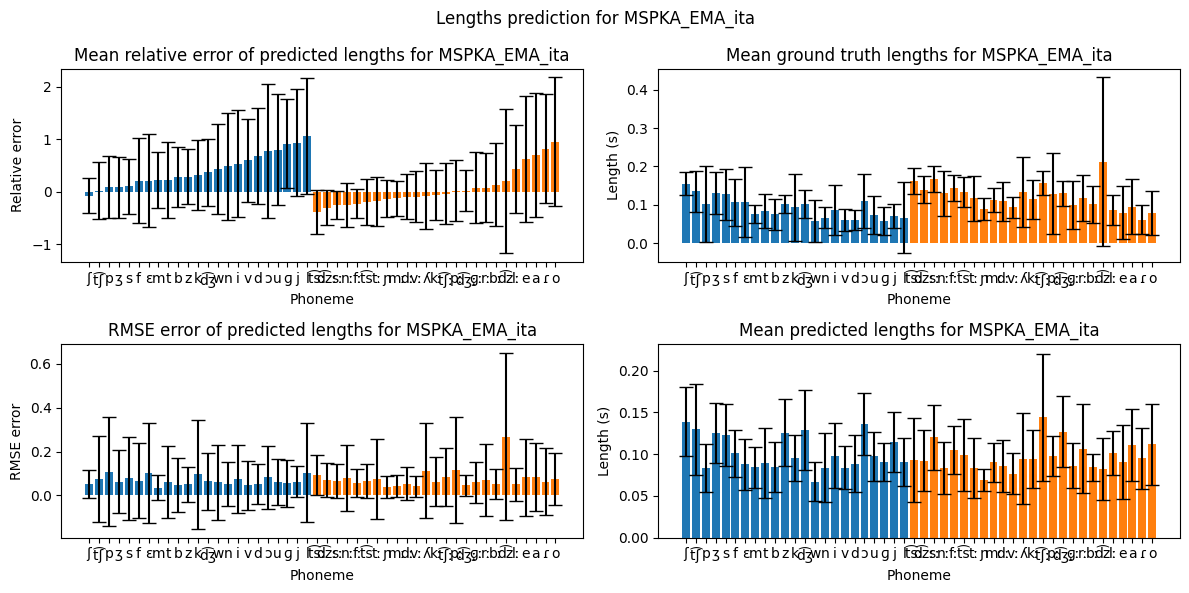

In [165]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

axes = ax.flatten()

phnms_regular_df = phnms_df[~phnms_df["extra_ipa"]]
phnms_extra_df = phnms_df[phnms_df["extra_ipa"]]
phnms_extra_df = phnms_extra_df.drop(index=["."])

phnms_stds_regular_df = phnms_stds_df.loc[phnms_regular_df.index]
phnms_stds_extra_df = phnms_stds_df.loc[phnms_extra_df.index]

axes[0].bar(phnms_regular_df.index, phnms_regular_df["len_err_rel"], yerr=phnms_stds_regular_df["len_err_rel"], capsize=5)
axes[0].bar(phnms_extra_df.index, phnms_extra_df["len_err_rel"], yerr=phnms_stds_extra_df["len_err_rel"], capsize=5)
axes[0].set_title(f"Mean relative error of predicted lengths for {dataset}")
axes[0].set_xlabel("Phoneme")
axes[0].set_ylabel("Relative error")

axes[1].bar(phnms_regular_df.index, phnms_regular_df["len_gt"], yerr=phnms_stds_regular_df["len_gt"], capsize=5)
axes[1].bar(phnms_extra_df.index, phnms_extra_df["len_gt"], yerr=phnms_stds_extra_df["len_gt"], capsize=5)
axes[1].set_title(f"Mean ground truth lengths for {dataset}")
axes[1].set_xlabel("Phoneme")
axes[1].set_ylabel("Length (s)")

axes[2].bar(phnms_regular_df.index, np.sqrt(phnms_regular_df["len_err2"]), yerr=np.sqrt(phnms_stds_regular_df["len_err2"]), capsize=5)
axes[2].bar(phnms_extra_df.index, np.sqrt(phnms_extra_df["len_err2"]), yerr=np.sqrt(phnms_stds_extra_df["len_err2"]), capsize=5)
axes[2].set_title(f"RMSE error of predicted lengths for {dataset}")
axes[2].set_xlabel("Phoneme")
axes[2].set_ylabel("RMSE error")

axes[3].bar(phnms_regular_df.index, phnms_regular_df["len_pred"], yerr=phnms_stds_regular_df["len_pred"], capsize=5)
axes[3].bar(phnms_extra_df.index, phnms_extra_df["len_pred"], yerr=phnms_stds_extra_df["len_pred"], capsize=5)
axes[3].set_title(f"Mean predicted lengths for {dataset}")
axes[3].set_xlabel("Phoneme")
axes[3].set_ylabel("Length (s)")

plt.suptitle(f"Lengths prediction for {dataset}")
plt.tight_layout()

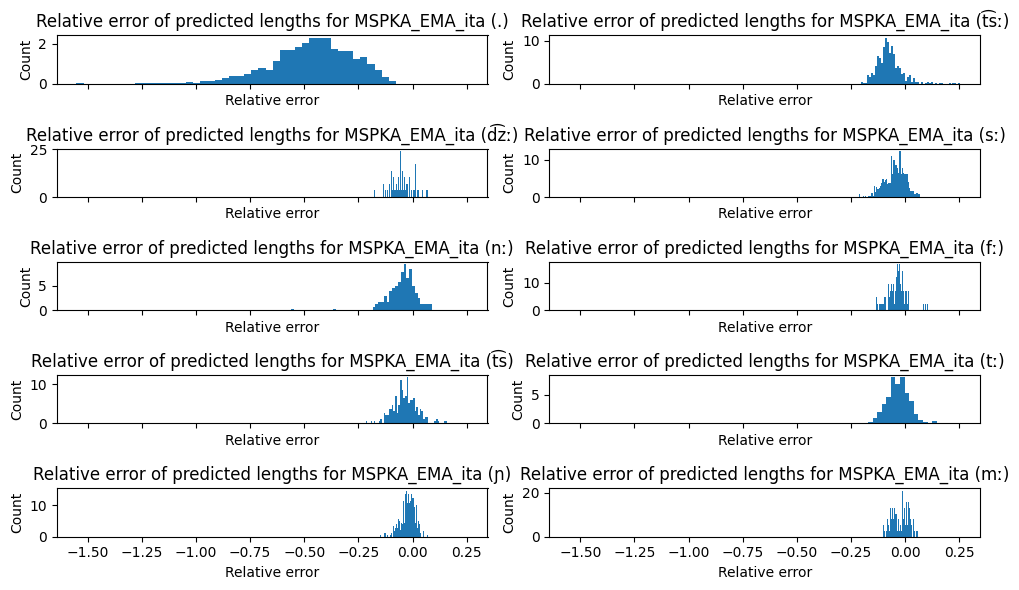

In [166]:
phnm = list(mspka_ipa_set)[2]
fig, ax = plt.subplots(5,2,figsize=(10, 6), sharex=True)
axes = ax.flatten()
for i, phnm in enumerate(phnms_df.index[:10]):
    truc = summary_df[summary_df["phnms"] == phnm]
    axes[i].hist(truc["len_err"], density=True, bins=50)
    axes[i].set_title(f"Relative error of predicted lengths for {dataset} ({phnm})")
    axes[i].set_xlabel("Relative error")
    axes[i].set_ylabel("Count")
plt.tight_layout()

## mocha_timit

In [167]:
dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]

In [168]:
from text.phnms import get_phnms_from_phnm3, get_lengths_from_phnm3

summary_df = None

model.eval()
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    dataset_obj = PhnmArticDataset(
        f"resources/filelists/{dataset}/{speaker}_v1.txt",
        data_root_dir=DATA_DIR,
        load_coder=False,
        merge_diphtongues=params_v1.merge_diphtongues,
    )
    filepaths_list = dataset_obj.filepaths_list
    for e in tqdm(filepaths_list):
        sample_id = Path(e[0]).stem
        phnm3_fp = e[1]
        phnm3_abs_fp = phnm3_fp.replace("DUMMY/", str(DATA_DIR) + "/")
        phnm3 = np.load(phnm3_abs_fp)
        len_gt = get_lengths_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=params_v1.merge_diphtongues)
        # Load the phoneme embedding
        phnm_emb = dataset_obj.get_phnm_emb(phnm3_fp)
        phnm_embs = [{"x" : phnm_emb} for i in range(1)]
        batch = collator(phnm_embs)
        x = batch["x"].to(torch.float32)
        x_lengths = batch["x_lengths"]
        # predict lengths
        frames_pred = model.lengths_pred(x, x_lengths).squeeze().squeeze()  # (B, T_x) -> (T_x,)
        len_pred =  frames_pred / 50
        uplen_pred = torch.ceil(frames_pred) / 50
        file_df = pd.DataFrame({
                "sample_id": [sample_id for _ in range(len(phnms))],
                "speaker": [speaker for _ in range(len(phnms))],
                "phnms": phnms,
                "len_gt": len_gt.tolist(),
                "len_pred": len_pred.tolist(),
                "uplen_pred": uplen_pred.tolist(),
                })
        if summary_df is None:
            summary_df = file_df
        else:
            summary_df = pd.concat([summary_df, file_df], ignore_index=True)
    summary_df[summary_df["speaker"] == speaker].to_csv(analysis_dir / "lengths_preds.csv", index=False)
        
summary_df

100%|██████████| 459/459 [00:11<00:00, 38.87it/s]


,sample_id,speaker,phnms,len_gt,len_pred,uplen_pred
0,fsew0_225,fsew0,.,0.520000,0.038697,0.04
1,fsew0_225,fsew0,k,0.110000,0.034918,0.04
2,fsew0_225,fsew0,ɔː,0.110000,0.107412,0.12
3,fsew0_225,fsew0,ɹ,0.100000,0.066632,0.08
4,fsew0_225,fsew0,i,0.150000,0.053848,0.06
...,...,...,...,...,...,...
95925,msak0_350,msak0,ə,0.030000,0.092933,0.10
95926,msak0_350,msak0,d,0.050000,0.076762,0.08
95927,msak0_350,msak0,e,0.115000,0.070863,0.08
95928,msak0_350,msak0,ɪ,0.115000,0.106226,0.12


In [170]:
summary_df = None
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    speaker_df = pd.read_csv(analysis_dir / "lengths_preds.csv")
    if summary_df is None:
        summary_df = speaker_df
    else:
        summary_df = pd.concat([summary_df, speaker_df], ignore_index=True)

summary_df["len_err"] = summary_df["len_pred"] - summary_df["len_gt"]
summary_df["uplen_err"] = summary_df["uplen_pred"] - summary_df["len_gt"]
summary_df["len_err2"] = (summary_df["len_pred"] - summary_df["len_gt"])**2
summary_df["uplen_err2"] = (summary_df["uplen_pred"] - summary_df["len_gt"])**2
summary_df["len_err_rel"] = summary_df["len_err"] / summary_df["len_gt"]
summary_df["uplen_err_rel"] = summary_df["uplen_err"] / summary_df["len_gt"]

In [171]:
mocha_ipa_set = set(summary_df["phnms"])
extra_ipa_set = mocha_ipa_set - lj_ipa_set
phnms_df = summary_df.groupby("phnms")[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']].mean().sort_values(by="len_err_rel")
phnms_stds_df = summary_df.groupby("phnms")[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                'uplen_err', 'len_err2', 'uplen_err2',
                                'len_err_rel', 'uplen_err_rel']].std().sort_values(by="len_err_rel")
phnms_df["extra_ipa"] = phnms_df.index.isin(extra_ipa_set)

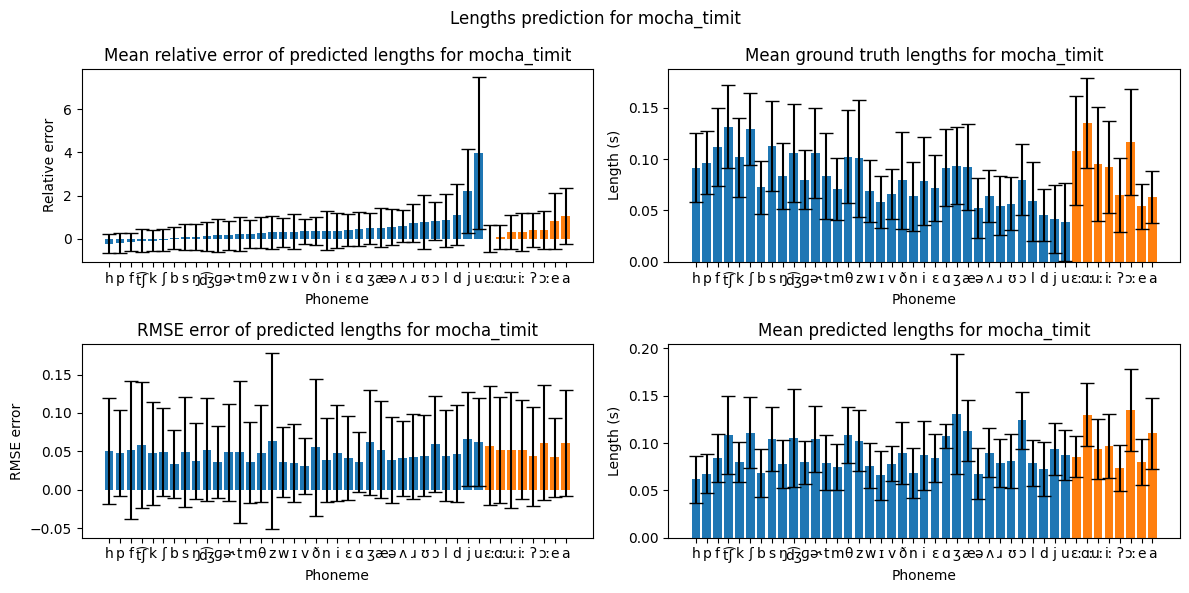

In [173]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

axes = ax.flatten()

phnms_regular_df = phnms_df[~phnms_df["extra_ipa"]]
phnms_extra_df = phnms_df[phnms_df["extra_ipa"]]
phnms_extra_df = phnms_extra_df.drop(index=["."])

phnms_stds_regular_df = phnms_stds_df.loc[phnms_regular_df.index]
phnms_stds_extra_df = phnms_stds_df.loc[phnms_extra_df.index]

axes[0].bar(phnms_regular_df.index, phnms_regular_df["len_err_rel"], yerr=phnms_stds_regular_df["len_err_rel"], capsize=5)
axes[0].bar(phnms_extra_df.index, phnms_extra_df["len_err_rel"], yerr=phnms_stds_extra_df["len_err_rel"], capsize=5)
axes[0].set_title(f"Mean relative error of predicted lengths for {dataset}")
axes[0].set_xlabel("Phoneme")
axes[0].set_ylabel("Relative error")

axes[1].bar(phnms_regular_df.index, phnms_regular_df["len_gt"], yerr=phnms_stds_regular_df["len_gt"], capsize=5)
axes[1].bar(phnms_extra_df.index, phnms_extra_df["len_gt"], yerr=phnms_stds_extra_df["len_gt"], capsize=5)
axes[1].set_title(f"Mean ground truth lengths for {dataset}")
axes[1].set_xlabel("Phoneme")
axes[1].set_ylabel("Length (s)")

axes[2].bar(phnms_regular_df.index, np.sqrt(phnms_regular_df["len_err2"]), yerr=np.sqrt(phnms_stds_regular_df["len_err2"]), capsize=5)
axes[2].bar(phnms_extra_df.index, np.sqrt(phnms_extra_df["len_err2"]), yerr=np.sqrt(phnms_stds_extra_df["len_err2"]), capsize=5)
axes[2].set_title(f"RMSE error of predicted lengths for {dataset}")
axes[2].set_xlabel("Phoneme")
axes[2].set_ylabel("RMSE error")

axes[3].bar(phnms_regular_df.index, phnms_regular_df["len_pred"], yerr=phnms_stds_regular_df["len_pred"], capsize=5)
axes[3].bar(phnms_extra_df.index, phnms_extra_df["len_pred"], yerr=phnms_stds_extra_df["len_pred"], capsize=5)
axes[3].set_title(f"Mean predicted lengths for {dataset}")
axes[3].set_xlabel("Phoneme")
axes[3].set_ylabel("Length (s)")

plt.suptitle(f"Lengths prediction for {dataset}")
plt.tight_layout()

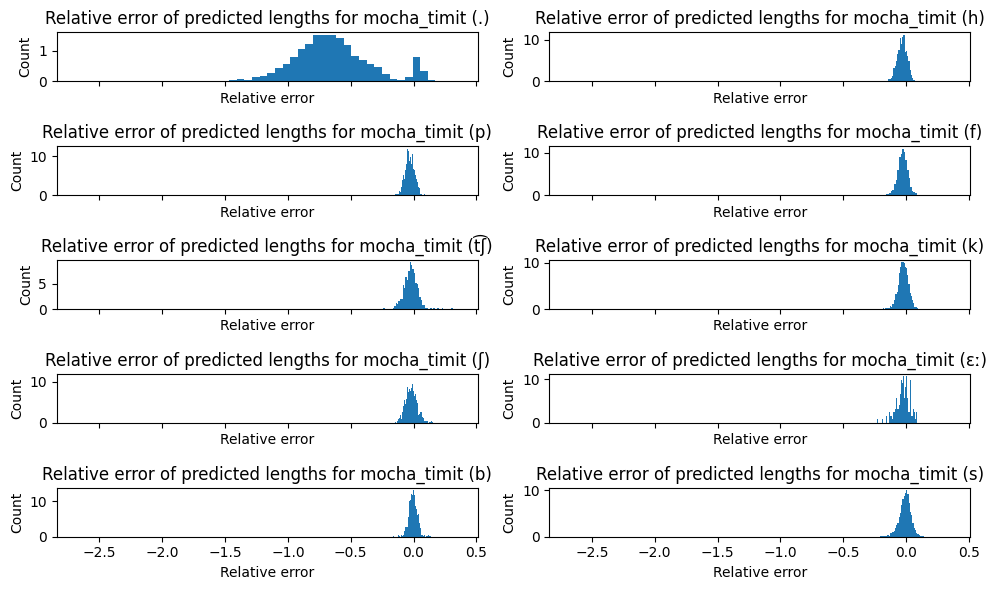

In [174]:
phnm = list(mocha_ipa_set)[2]
fig, ax = plt.subplots(5,2,figsize=(10, 6), sharex=True)
axes = ax.flatten()
for i, phnm in enumerate(phnms_df.index[:10]):
    truc = summary_df[summary_df["phnms"] == phnm]
    axes[i].hist(truc["len_err"], density=True, bins=50)
    axes[i].set_title(f"Relative error of predicted lengths for {dataset} ({phnm})")
    axes[i].set_xlabel("Relative error")
    axes[i].set_ylabel("Count")
plt.tight_layout()

## inter datasets

In [254]:
#get list of sentence samples in pb2007 dataset
import utils_ema.ema_dataset
import joblib

processed_data_dir = DATA_DIR / "pb2007" / "processed_data"
spkmetadata_filename = '1.0_speaker_metadata_100Hz.joblib'
spkmeta = joblib.load(processed_data_dir / f"spk1/{spkmetadata_filename}")
sentence_items = []
for id in spkmeta.list_valid_ids():
    if spkmeta.sentence_info[id].sentence_type == "sentence":
        sentence_items.append(spkmeta.sentence_info[id].filestem)

In [271]:
def get_dataset_summary_df(dataset, speakers):
    summary_df = None
    for speaker in speakers:
        analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
        speaker_df = pd.read_csv(analysis_dir / "lengths_preds.csv")
        if summary_df is None:
            summary_df = speaker_df
        else:
            summary_df = pd.concat([summary_df, speaker_df], ignore_index=True)
    summary_df["len_err"] = summary_df["len_pred"] - summary_df["len_gt"]
    summary_df["uplen_err"] = summary_df["uplen_pred"] - summary_df["len_gt"]
    summary_df["len_err2"] = (summary_df["len_pred"] - summary_df["len_gt"])**2
    summary_df["uplen_err2"] = (summary_df["uplen_pred"] - summary_df["len_gt"])**2
    summary_df["len_err_rel"] = summary_df["len_err"] / summary_df["len_gt"]
    summary_df["uplen_err_rel"] = summary_df["uplen_err"] / summary_df["len_gt"]
    summary_df = summary_df[summary_df['phnms'] != '.']
    summary_df.loc[:,"abs_err_rel"] = np.abs(summary_df["len_err_rel"])
    summary_df = summary_df[['len_gt', 'len_pred', 'uplen_pred', 'len_err',
                                    'uplen_err', 'len_err2', 'uplen_err2',
                                    'len_err_rel', 'uplen_err_rel', 'abs_err_rel']].describe()
    summary_df[['len_err2', 'uplen_err2']] = np.sqrt(summary_df[['len_err2', 'uplen_err2']])
    return summary_df

dataset = "MNGU0"
speakers = ["s1"]
mngu0_df = get_dataset_summary_df(dataset, speakers)

dataset = "pb2007"
speakers = ["spk1"]
pb2007_df = get_dataset_summary_df(dataset, speakers)

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]
mspka_df = get_dataset_summary_df(dataset, speakers)

dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]
mocha_df = get_dataset_summary_df(dataset, speakers)

/tmp/ipykernel_20945/3877047538.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df.loc[:,"abs_err_rel"] = np.abs(summary_df["len_err_rel"])
/tmp/ipykernel_20945/3877047538.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df.loc[:,"abs_err_rel"] = np.abs(summary_df["len_err_rel"])


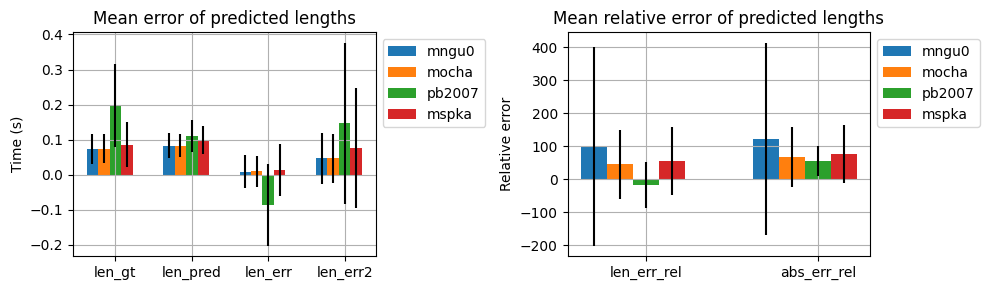

In [272]:
features1 = ['len_gt', 'len_pred', 'len_err', 'len_err2']
x = np.arange(len(features1))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# First subplot
ax[0].bar(x - 2*width, mngu0_df.loc["mean"][features1], width,
          yerr=mngu0_df.loc["std"][features1], label="mngu0")
ax[0].bar(x - width, mocha_df.loc["mean"][features1], width,
          yerr=mocha_df.loc["std"][features1], label="mocha")
ax[0].bar(x, pb2007_df.loc["mean"][features1], width,
          yerr=pb2007_df.loc["std"][features1], label="pb2007")
ax[0].bar(x + width, mspka_df.loc["mean"][features1], width,
          yerr=mspka_df.loc["std"][features1], label="mspka")
ax[0].set_title("Mean error of predicted lengths")
ax[0].set_ylabel("Time (s)")
ax[0].set_xticks(x)
ax[0].set_xticklabels(features1)
ax[0].grid()
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

features2 = ['len_err_rel', 'abs_err_rel']
x = np.arange(len(features2))  # the label locations
ax[1].bar(x - 2*width, 100*mngu0_df.loc["mean"][features2], width,
          yerr=100*mngu0_df.loc["std"][features2], label="mngu0")
ax[1].bar(x - width, 100*mocha_df.loc["mean"][features2], width,
          yerr=100*mocha_df.loc["std"][features2], label="mocha")
ax[1].bar(x, 100*pb2007_df.loc["mean"][features2], width,
          yerr=100*pb2007_df.loc["std"][features2], label="pb2007")
ax[1].bar(x + width, 100*mspka_df.loc["mean"][features2], width,
          yerr=100*mspka_df.loc["std"][features2], label="mspka")
ax[1].set_title("Mean relative error of predicted lengths")
ax[1].set_ylabel("Relative error")
ax[1].set_xticks(x)
ax[1].set_xticklabels(features2)
ax[1].grid()
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()